In [1]:
import numpy as np
import os
import sys
import glob
import uproot as ur
import matplotlib.pyplot as plt
import time
import seaborn as sns
import tensorflow as tf
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.graphs import GraphsTuple
import sonnet as snt
import argparse
import yaml
import logging
import tensorflow as tf

from gn4pions.modules.data import GraphDataGenerator
# from gn4pions.modules.models import MultiOutWeightedRegressModel
from gn4pions.modules.models import MLPGraphNetwork
from gn4pions.modules.utils import convert_to_tuple

sns.set_context('poster')

In [2]:
# Loading model config
config_file = 'gn4pions/configs/classification.yaml'
config = yaml.load(open(config_file), Loader=yaml.FullLoader)

# Data config
data_config = config['data']

data_dir = data_config['data_dir']
num_train_files = data_config['num_train_files']
num_val_files = data_config['num_val_files']
batch_size = data_config['batch_size']
shuffle = data_config['shuffle']
num_procs = data_config['num_procs']
preprocess = data_config['preprocess']
output_dir = data_config['output_dir']
already_preprocessed = data_config['already_preprocessed']  # Set to false when running training for first time

# Model Config
model_config = config['model']

concat_input = model_config['concat_input']


# Traning Config
train_config = config['training']

epochs = train_config['epochs']
learning_rate = train_config['learning_rate']
alpha = train_config['alpha']
os.environ['CUDA_VISIBLE_DEVICES'] = str(train_config['gpu'])
log_freq = train_config['log_freq']
save_dir = train_config['save_dir'] + config_file.replace('.yaml','').split('/')[-1] + '_' + time.strftime("%Y%m%d")

os.makedirs(save_dir, exist_ok=True)
yaml.dump(config, open(save_dir + '/config.yaml', 'w'))


In [3]:
# Read data and create data generators

pi0_files = np.sort(glob.glob(data_dir+'*pi0*/*root'))
pion_files = np.sort(glob.glob(data_dir+'*pion*/*root'))

train_start = 0
train_end = train_start + num_train_files
val_end = train_end + num_val_files

pi0_train_files = pi0_files[train_start:train_end]
pi0_val_files = pi0_files[train_end:val_end]
pion_train_files = pion_files[train_start:train_end]
pion_val_files = pion_files[train_end:val_end]

train_output_dir = None
val_output_dir = None

# Get Data
if preprocess:
    train_output_dir = output_dir + '/train/'
    val_output_dir = output_dir + '/val/'

    if already_preprocessed:
        train_files = np.sort(glob.glob(train_output_dir+'*.p'))[:num_train_files]
        val_files = np.sort(glob.glob(val_output_dir+'*.p'))[:num_val_files]

        pi0_train_files = train_files
        pi0_val_files = val_files
        pion_train_files = None
        pion_val_files = None

        train_output_dir = None
        val_output_dir = None

# Traning Data Generator
# Will preprocess data if it doesnt find pickled files
data_gen_train = GraphDataGenerator(pi0_file_list=pi0_train_files,
                                    pion_file_list=pion_train_files,
                                    cellGeo_file=data_dir+'CellGeo.neighbours.root',
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_procs=num_procs,
                                    preprocess=preprocess,
                                    output_dir=train_output_dir)

# Validation Data generator
# Will preprocess data if it doesnt find pickled files
data_gen_val = GraphDataGenerator(pi0_file_list=pi0_val_files,
                                  pion_file_list=pion_val_files,
                                  cellGeo_file=data_dir+'CellGeo.neighbours.root',
                                  batch_size=batch_size,
                                  shuffle=shuffle,
                                  num_procs=num_procs,
                                  preprocess=preprocess,
                                  output_dir=val_output_dir)


In [4]:
# Get batch of data
def get_batch(data_iter):
    for graphs, targets in data_iter:
        graphs = convert_to_tuple(graphs)
        targets = tf.convert_to_tensor(targets)
        yield graphs, targets
        
# Define loss function
mae_loss = tf.keras.losses.MeanAbsoluteError()
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# weighted regression loss:
# def loss_fn(targets, regress_preds, class_preds):
#     regress_loss = mae_loss(targets[:,:1], regress_preds)
#     class_loss = bce_loss(targets[:,1:], class_preds)
#     combined_loss = alpha*regress_loss + (1 - alpha)*class_loss 
#     return regress_loss, class_loss, combined_loss

def loss_fn(targets, class_preds):
    class_loss = bce_loss(targets[:,1:], class_preds)
    return class_loss



In [5]:
# Get a sample graph for tf.function decorator
samp_graph, samp_target = next(get_batch(data_gen_train.generator()))
data_gen_train.kill_procs()
graph_spec = utils_tf.specs_from_graphs_tuple(samp_graph, True, True, True)

# Traning set
# @tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
# def train_step(graphs, targets):
#     with tf.GradientTape() as tape:
#         regress_output, class_output = model(graphs)
#         regress_preds = regress_output.globals
#         class_preds = class_output.globals
#         regress_loss, class_loss, loss = loss_fn(targets, regress_preds, class_preds)

#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#     return regress_loss, class_loss, loss
@tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
def train_step(graphs, targets):
    with tf.GradientTape() as tape:
        class_output = model(graphs)
        print("class_output: " + str(class_output))
        class_preds = class_output.globals
        print("class_output.globals: " + str(class_output.globals))
        loss = loss_fn(targets, class_preds)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Validation Step
# @tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
# def val_step(graphs, targets):
#     regress_output, class_output = model(graphs)
#     regress_preds = regress_output.globals
#     class_preds = class_output.globals
#     regress_loss, class_loss, loss = loss_fn(targets, regress_preds, class_preds)
#     return regress_loss, class_loss, loss, regress_preds, class_preds
@tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
def val_step(graphs, targets):
    class_output = model(graphs)
    class_preds = class_output.globals
    loss = loss_fn(targets, class_preds)
    return loss, class_preds

2021-12-31 17:53:38.144509: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-31 17:53:38.643246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22537 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
# Model 
# model = MultiOutWeightedRegressModel(global_output_size=1, num_outputs=2, model_config=model_config)
model = MLPGraphNetwork(model_config=model_config)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Average epoch losses
training_loss_epoch = []
training_loss_regress_epoch = []
training_loss_class_epoch = []
val_loss_epoch = []
val_loss_regress_epoch = []
val_loss_class_epoch = []

# Model checkpointing, load latest model if available
checkpoint = tf.train.Checkpoint(module=model)
checkpoint_prefix = os.path.join(save_dir, 'latest_model')
latest = tf.train.latest_checkpoint(save_dir)
if latest is not None:
    checkpoint.restore(latest)
else:
    checkpoint.save(checkpoint_prefix)

In [10]:
model.variables

2021-12-31 17:54:46.035025: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


ValueError: MLPGraphNetwork(
    model_config={'block_type': 'graphnet',
                  'concat_input': True,
                  'edge_block_opt': {'use_edges': True,
                                     'use_globals': True,
                                     'use_receiver_nodes': True,
                                     'use_sender_nodes': True},
                  'global_block_opt': {'use_edges': True,
                                       'use_globals': True,
                                       'use_nodes': True},
                  'latent_size': 64,
                  'node_block_opt': {'use_globals': True,
                                     'use_nodes': True,
                                     'use_received_edges': True,
                                     'use_sent_edges': True},
                  'num_blocks': 4,
                  'num_layers': 4,
                  'reducer': 'mean'},
) does not currently contain any variables.

Most Sonnet modules create variables the first time they are called with an
input and requesting variables before this typically indicates a coding error.

You should refactor your code such that you request module variables after you
pass an example input to the module. For example:

    module = MLPGraphNetwork(
    model_config={'block_type': 'graphnet',
                  'concat_input': True,
                  'edge_block_opt': {'use_edges': True,
                                     'use_globals': True,
                                     'use_receiver_nodes': True,
                                     'use_sender_nodes': True},
                  'global_block_opt': {'use_edges': True,
                                       'use_globals': True,
                                       'use_nodes': True},
                  'latent_size': 64,
                  'node_block_opt': {'use_globals': True,
                                     'use_nodes': True,
                                     'use_received_edges': True,
                                     'use_sent_edges': True},
                  'num_blocks': 4,
                  'num_layers': 4,
                  'reducer': 'mean'},
)
    output = module(input)
    params = module.variables

If the module is stateless consider using `snt.allow_empty_variables(module)` to
suppress this error:

    module = MLPGraphNetwork(
    model_config={'block_type': 'graphnet',
                  'concat_input': True,
                  'edge_block_opt': {'use_edges': True,
                                     'use_globals': True,
                                     'use_receiver_nodes': True,
                                     'use_sender_nodes': True},
                  'global_block_opt': {'use_edges': True,
                                       'use_globals': True,
                                       'use_nodes': True},
                  'latent_size': 64,
                  'node_block_opt': {'use_globals': True,
                                     'use_nodes': True,
                                     'use_received_edges': True,
                                     'use_sent_edges': True},
                  'num_blocks': 4,
                  'num_layers': 4,
                  'reducer': 'mean'},
)
    snt.allow_empty_variables(module)
    params = module.variables

You can annotate your own subclasses directly if you prefer:

    @snt.allow_empty_variables
    class MyStatelessModule(snt.Module):
      pass

In [14]:
# Run training
curr_loss = 1e5

for e in range(epochs):

    print(f'\n\nStarting epoch: {e}')
    epoch_start = time.time()
    
    # Batchwise losses
    training_loss = []
    training_loss_regress = []
    training_loss_class = []
    val_loss = []
    val_loss_regress = []
    val_loss_class = []

    # Train
    print('Training...')
    start = time.time()
    for i, (graph_data_tr, targets_tr) in enumerate(get_batch(data_gen_train.generator())):
#         losses_tr_rg, losses_tr_cl, losses_tr = train_step(graph_data_tr, targets_tr)
        losses_tr = train_step(graph_data_tr, targets_tr)

        training_loss.append(losses_tr.numpy())
#         training_loss_regress.append(losses_tr_rg.numpy())
#         training_loss_class.append(losses_tr_cl.numpy())

        if not (i-1)%log_freq:
            end = time.time()
            print(f'Iter: {i:04d}, ', end='')
            print(f'Tr_loss_mean: {np.mean(training_loss):.4f}, ', end='')
#             print(f'Tr_loss_rg_mean: {np.mean(training_loss_regress):.4f}, ', end='') 
#             print(f'Tr_loss_cl_mean: {np.mean(training_loss_class):.4f}, ', end='') 
            print(f'Took {end-start:.4f}secs')
            start = time.time()
                  
    training_loss_epoch.append(training_loss)
#     training_loss_regress_epoch.append(training_loss_regress)
#     training_loss_class_epoch.append(training_loss_class)
    training_end = time.time()

    # validate
    print('\nValidation...')
    all_targets = []
    all_outputs = []
    start = time.time()
    for i, (graph_data_val, targets_val) in enumerate(get_batch(data_gen_val.generator())):
#         losses_val_rg, losses_val_cl, losses_val, regress_vals, class_vals = val_step(graph_data_val, targets_val)
        losses_val, class_vals = val_step(graph_data_val, targets_val)

        targets_val = targets_val.numpy()
#         regress_vals = regress_vals.numpy()
        class_vals = class_vals.numpy()

        targets_val[:,0] = 10**targets_val[:,0]
#         regress_vals = 10**regress_vals
        class_vals =  tf.math.sigmoid(class_vals)

        output_vals = np.hstack([regress_vals, class_vals])

        val_loss.append(losses_val.numpy())
#         val_loss_regress.append(losses_val_rg.numpy())
        val_loss_class.append(losses_val_cl.numpy())

        all_targets.append(targets_val)
        all_outputs.append(output_vals)

        if not (i-1)%log_freq:
            end = time.time()
            print(f'Iter: {i:04d}, ', end='')
            print(f'Val_loss_mean: {np.mean(val_loss):.4f}, ', end='')
#             print(f'Val_loss_rg_mean: {np.mean(val_loss_regress):.4f}, ', end='') 
#             print(f'Val_loss_cl_mean: {np.mean(val_loss_class):.4f}, ', end='') 
            print(f'Took {end-start:.4f}secs')
            start = time.time()

    epoch_end = time.time()

    all_targets = np.concatenate(all_targets)
    all_outputs = np.concatenate(all_outputs)

    val_loss_epoch.append(val_loss)
#     val_loss_regress_epoch.append(val_loss_regress)
    val_loss_class_epoch.append(val_loss_class)

    
    # Book keeping
    val_mins = int((epoch_end - training_end)/60)
    val_secs = int((epoch_end - training_end)%60)
    training_mins = int((training_end - epoch_start)/60)
    training_secs = int((training_end - epoch_start)%60)
    print(f'\nEpoch {e} ended')
    print(f'Training: {training_mins:2d}:{training_secs:02d}')
    print(f'Validation: {val_mins:2d}:{val_secs:02d}')
    
    
    # Save losses
    np.savez(save_dir+'/losses', 
            training=training_loss_epoch, validation=val_loss_epoch,
            training_regress=training_loss_regress_epoch, validation_regress=val_loss_regress_epoch,
            training_class=training_loss_class_epoch, validation_class=val_loss_class_epoch,
            )

    
    # Checkpoint if validation loss improved
    if np.mean(val_loss)<curr_loss:
        print(f'Loss decreased from {curr_loss:.4f} to {np.mean(val_loss):.4f}')
        print(f'Checkpointing and saving predictions to:\n{save_dir}')
        curr_loss = np.mean(val_loss)
        np.savez(save_dir+'/predictions', 
                targets=all_targets, 
                outputs=all_outputs)
        checkpoint.save(checkpoint_prefix)
    else: 
        print(f'Loss didnt decrease from {curr_loss:.4f}')
    
    
    # Decrease learning rate every few epochs
    if not (e+1)%2:   #%20:
        optimizer.learning_rate = optimizer.learning_rate/10
        print(f'Learning rate decreased to: {optimizer.learning_rate.value():.3e}')



Starting epoch: 0
Training...
GraphsTuple(nodes=<tf.Tensor 'MLPGraphNetwork/graph_network/node_block/layer_norm/batchnorm/add_1:0' shape=(None, 64) dtype=float32>, edges=<tf.Tensor 'MLPGraphNetwork/graph_network/edge_block/layer_norm/batchnorm/add_1:0' shape=(None, 64) dtype=float32>, receivers=<tf.Tensor 'graphs_2:0' shape=(None,) dtype=int32>, senders=<tf.Tensor 'graphs_3:0' shape=(None,) dtype=int32>, globals=<tf.Tensor 'MLPGraphNetwork/graph_network/global_block/layer_norm/batchnorm/add_1:0' shape=(None, 64) dtype=float32>, n_node=<tf.Tensor 'graphs_5:0' shape=(None,) dtype=int64>, n_edge=<tf.Tensor 'graphs_6:0' shape=(None,) dtype=int64>)


ValueError: in user code:

    /tmp/ipykernel_7623/2085968999.py:24 train_step  *
        loss = loss_fn(targets, class_preds)
    /tmp/ipykernel_7623/3924948353.py:19 loss_fn  *
        class_loss = bce_loss(targets[:,1:], class_preds)
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/keras/losses.py:141 __call__  **
        losses = call_fn(y_true, y_pred)
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/keras/losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/keras/backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 64) vs (None, 1))


Process Process-115:
Process Process-120:
Process Process-118:
Process Process-113:
Process Process-116:
Process Process-117:
Process Process-112:
Process Process-111:
Process Process-114:
Process Process-119:
Process Process-105:
Process Process-108:
Process Process-110:
Process Process-109:
Process Process-102:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/home/us

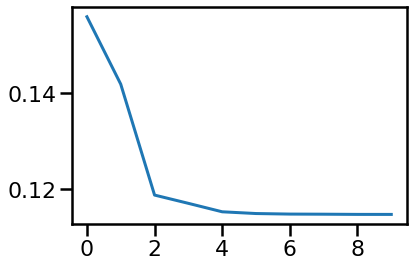

In [13]:
plt.plot([np.mean(x) for x in val_loss_epoch])